In [2]:
import os
import seaborn as sns
import simplstyles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from voxelwise_tutorials.io import load_hdf5_array
from voxelwise_tutorials.viz import plot_flatmap_from_mapper

from results import get_result_path

In [3]:
plt.style.use("nord-light-talk")

In [4]:
subject = 5
modality = "reading"
low_level_features = ["letters", "moten"]

In [5]:
mapper_path = os.path.join("../../data", 'mappers', f"subject{subject:02}_mappers.hdf")
mapper = load_hdf5_array(mapper_path)
flatmap_mask = mapper['flatmap_mask']

In [6]:
v1_mask = mapper['roi_mask_V1']
v2_mask = mapper['roi_mask_V2']
v3_mask = mapper['roi_mask_V3']
all_masks = v1_mask + v2_mask + v3_mask
# set all values > 0 to 1
all_masks[all_masks > 0] = 1
all_masks = all_masks.astype(bool)

In [7]:
semantic_path = os.path.join(get_result_path(modality, subject), "english1000_scores.csv")
vp_paths = []
rm_paths = []
rm_ridge_paths = []
for low_level_feature in low_level_features:
    vp_paths.append(os.path.join(get_result_path(modality, subject), f"vp_english1000_{low_level_feature}_scores.csv"))
    rm_paths.append(
        os.path.join(get_result_path(modality, subject), f"residual_{low_level_feature}_english1000_scores.csv"))
    rm_ridge_paths.append(
        os.path.join(get_result_path(modality, subject), f"residual_ridge_{low_level_feature}_english1000_scores.csv"))

In [8]:
semantic = pd.read_csv(semantic_path)
semantic_correlation = np.array(semantic["correlation_score"])

vp_correlations = []
rm_correlations = []
rm_ridge_correlations = []

for i, low_level_feature in enumerate(low_level_features):
    vp = pd.read_csv(vp_paths[i])
    rm = pd.read_csv(rm_paths[i])
    rm_ridge = pd.read_csv(rm_ridge_paths[i])

    vp_correlation = np.array(vp[f"semantic\\{low_level_feature}"])
    rm_correlation = np.array(rm[f"correlation_score"])
    rm_ridge_correlation = np.array(rm_ridge[f"correlation_score"])

    vp_correlations.append(vp_correlation)
    rm_correlations.append(rm_correlation)
    rm_ridge_correlations.append(rm_ridge_correlation)

In [9]:
# Create a DataFrame
datas = []

for i, low_level_feature in enumerate(low_level_features):
    data = pd.DataFrame({
        'Semantic': semantic_correlation[all_masks],
        'Residual Method (ridge)': rm_ridge_correlations[i][all_masks],
        'Residual Method (OLS)': rm_correlations[i][all_masks],
        'Variance Partitioning': vp_correlations[i][all_masks],
    })
    datas.append(data)
# Display the DataFrame
print(datas)

[      Semantic  Residual Method (ridge)  Residual Method (OLS)  \
0     0.279863                 0.012883               0.012848   
1     0.023263                -0.007977              -0.007187   
2     0.020139                -0.011586              -0.013688   
3    -0.059456                -0.003787              -0.001047   
4     0.056028                -0.046691              -0.047252   
...        ...                      ...                    ...   
1568 -0.018312                 0.038859               0.040579   
1569 -0.052068                -0.045720              -0.037275   
1570 -0.031283                -0.017426              -0.014660   
1571  0.094611                 0.068671               0.066738   
1572 -0.007654                -0.060802              -0.063365   

      Variance Partitioning  
0                 -0.319425  
1                 -0.040986  
2                 -0.196006  
3                 -0.065263  
4                 -0.067975  
...                     ..

# Scatterplot of visual cortex

<Axes: >

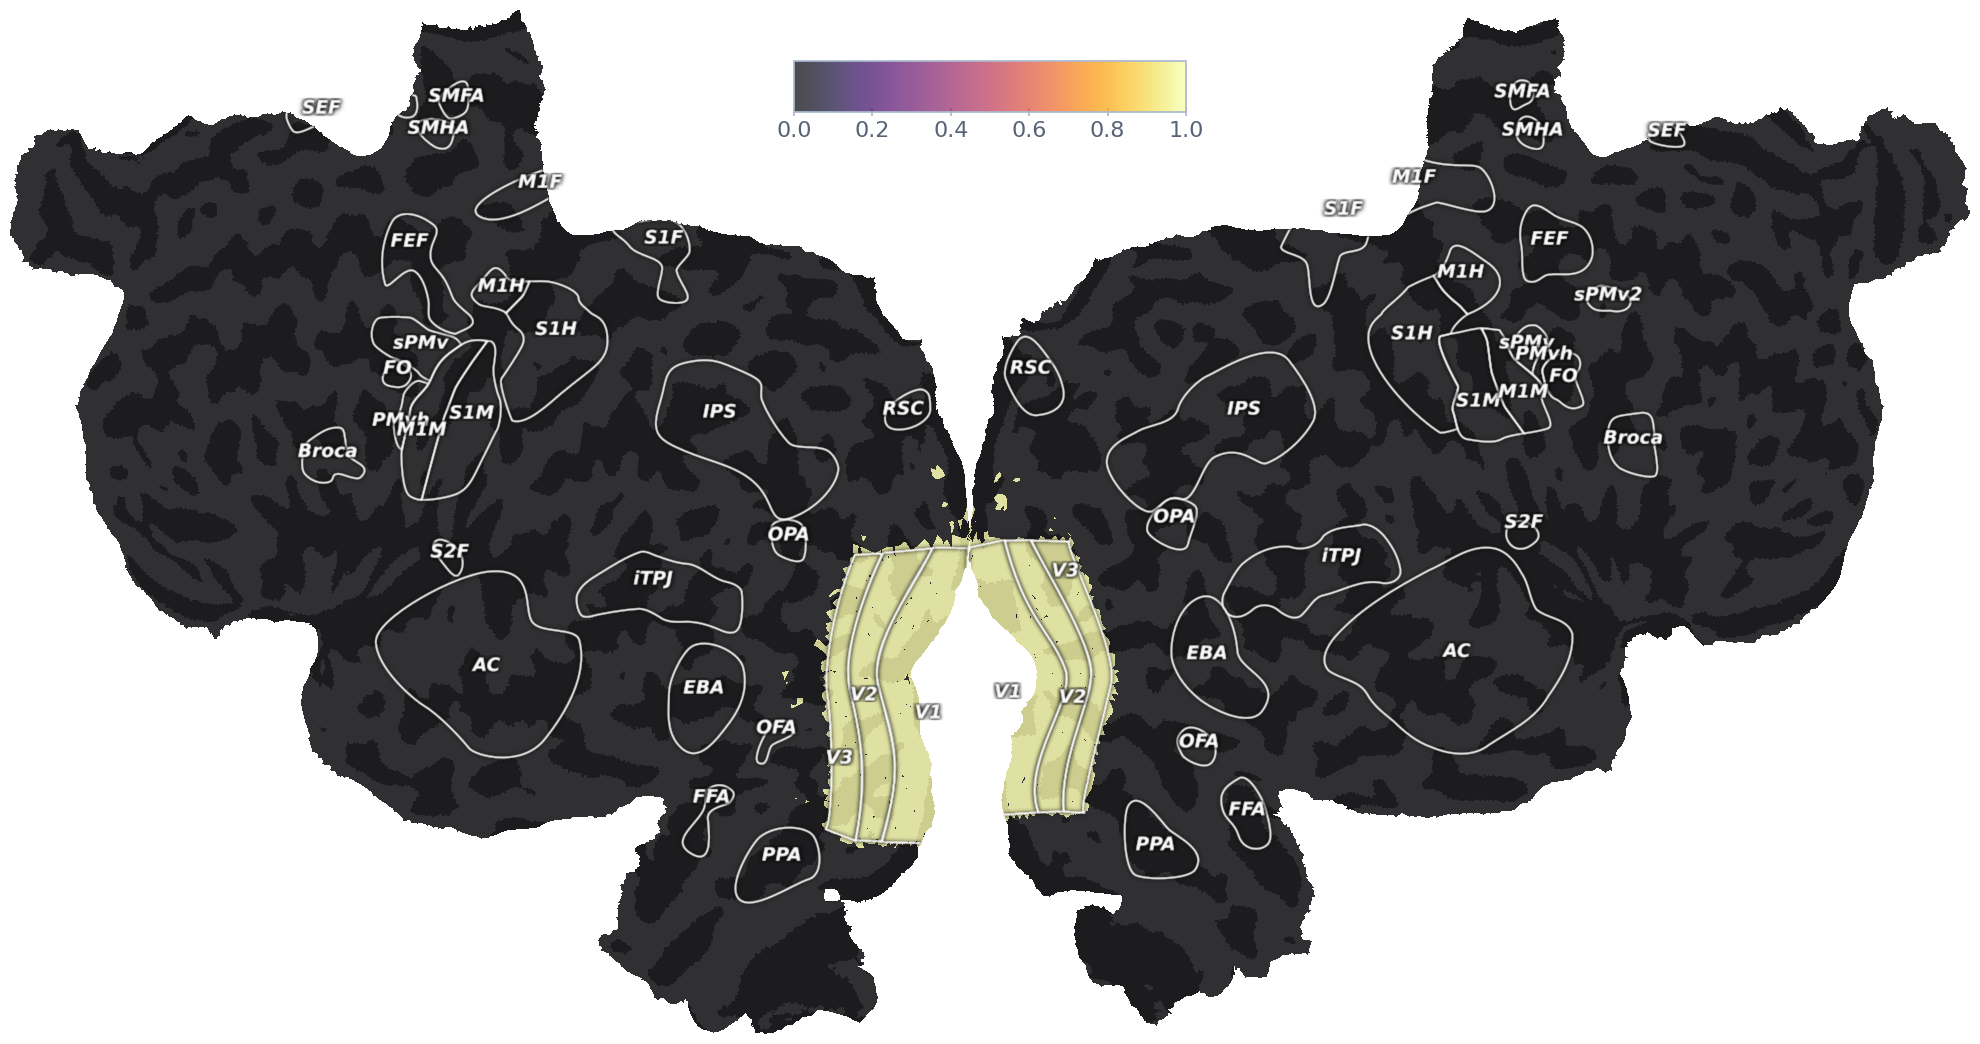

In [10]:
plot_flatmap_from_mapper(all_masks, mapper_path, vmin=0, vmax=all_masks.max())

# create all pairwise scatterplots in visualcorteces for semantic, variance partitioning, residual method ols and residual method ridge

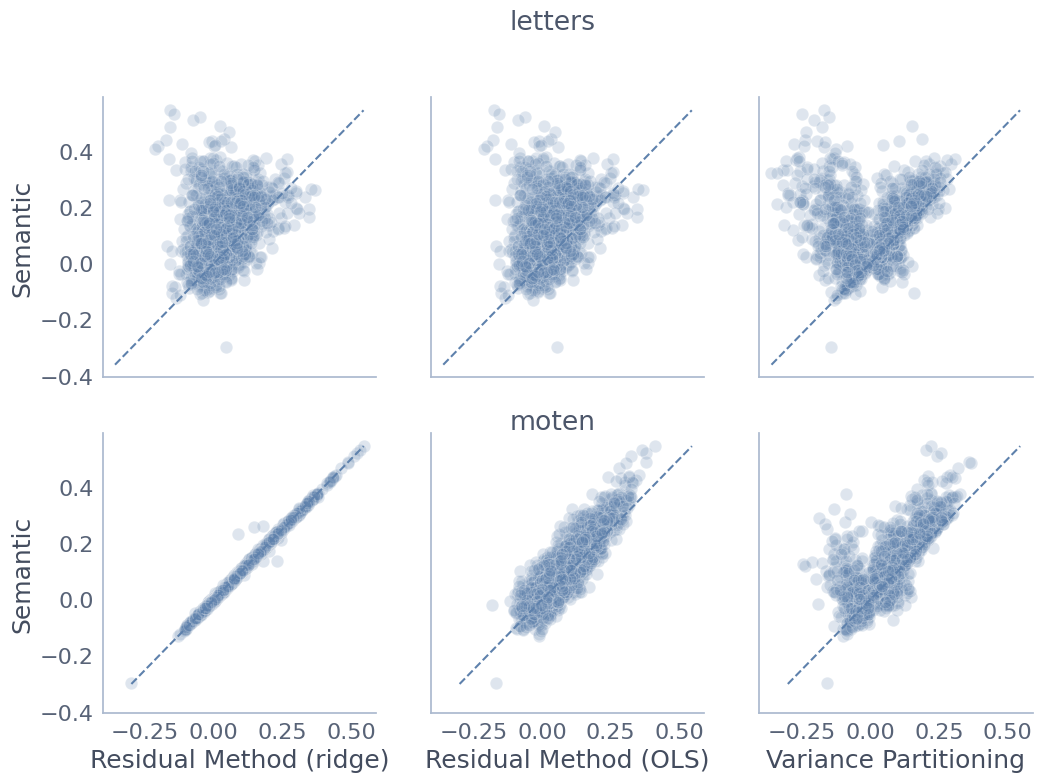

In [11]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
subfigs = fig.subfigures(nrows=2, ncols=1)

for i, low_level_feature in enumerate(low_level_features):
    _data = datas[i]
    vmin = _data.min().min()
    vmax = _data.max().max()

    for j, col in enumerate(_data.columns[1:]):
        sns.scatterplot(_data, x=col, y="Semantic", ax=axs[i, j], alpha=0.2)
        sns.lineplot(x=[vmin, vmax], y=[vmin, vmax], linestyle='--', ax=axs[i, j])
    subfigs[i].suptitle(low_level_feature)

Text(0, 0.5, 'VC Prediction Accuracy')

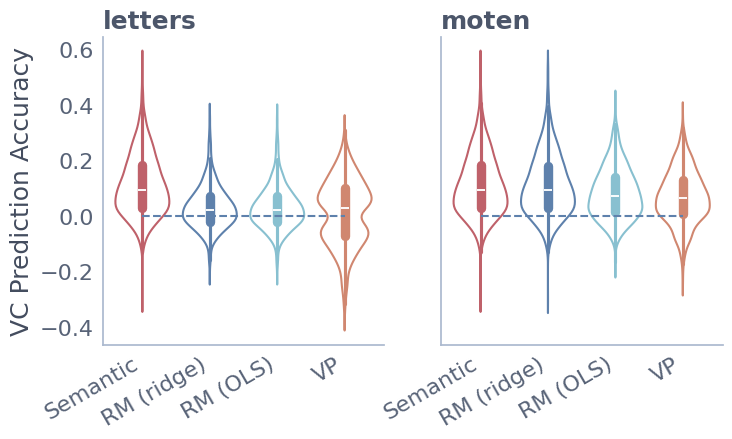

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

for i, low_level_feature in enumerate(low_level_features):

    _data = datas[i]
    _data.columns = ["Semantic", "RM (ridge)", "RM (OLS)", "VP"]

    for j, (column, color) in enumerate(zip(_data.columns, ["C3", "C0", "C1", "C2"])):
        sns.violinplot(_data, x=j, y=column, color=color, fill=False, ax=axs[i])

    axs[i].set_xticks(range(4), _data.columns, rotation=30, ha="right")
    axs[i].set_title(low_level_feature)
    axs[i].hlines(0, 0, 3, linestyle='--')

axs[0].set_ylabel("VC Prediction Accuracy")
# plt.tight_layout()

Compute amount removed compared to semantic

Text(0, 0.5, 'Semantic - Predicted')

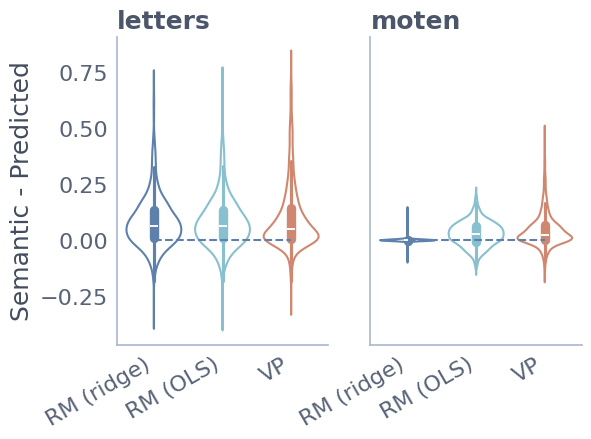

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(6, 4), sharex=True, sharey=True)

for i, low_level_feature in enumerate(low_level_features):
    _data = datas[i]
    data_removed = _data.iloc[:, 1:].apply(lambda x: _data.iloc[:, 0] - x)
    data_removed.columns = ["RM (ridge)", "RM (OLS)", "VP"]

    for j, (column, color) in enumerate(zip(data_removed.columns, ["C0", "C1", "C2"])):
        sns.violinplot(data_removed, x=j, y=column, color=color, fill=False, ax=axs[i])

    axs[i].set_xticks(range(3), data_removed.columns, rotation=30, ha="right")
    axs[i].set_title(low_level_feature)
    axs[i].hlines(0, 0, 2, linestyle='--')

    plt.xticks(range(3), data_removed.columns, rotation=30, ha="right")
axs[0].set_ylabel("Semantic - Predicted")

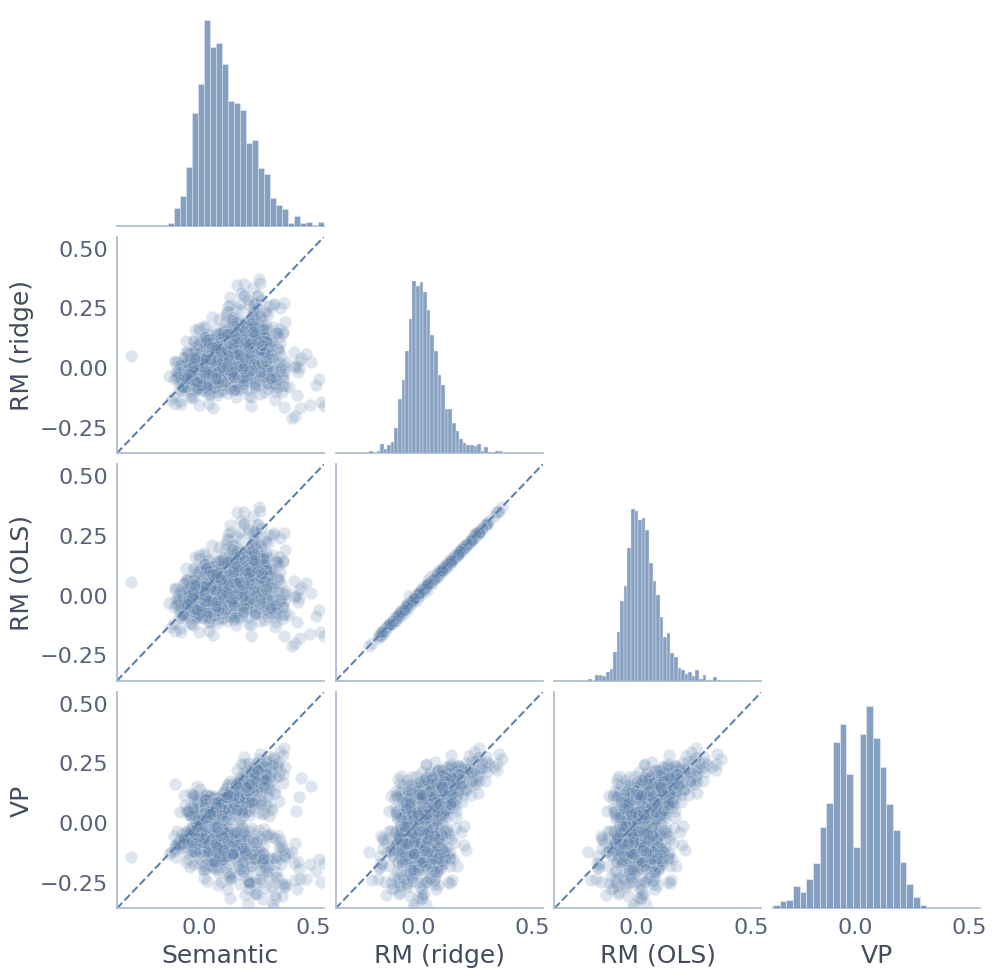

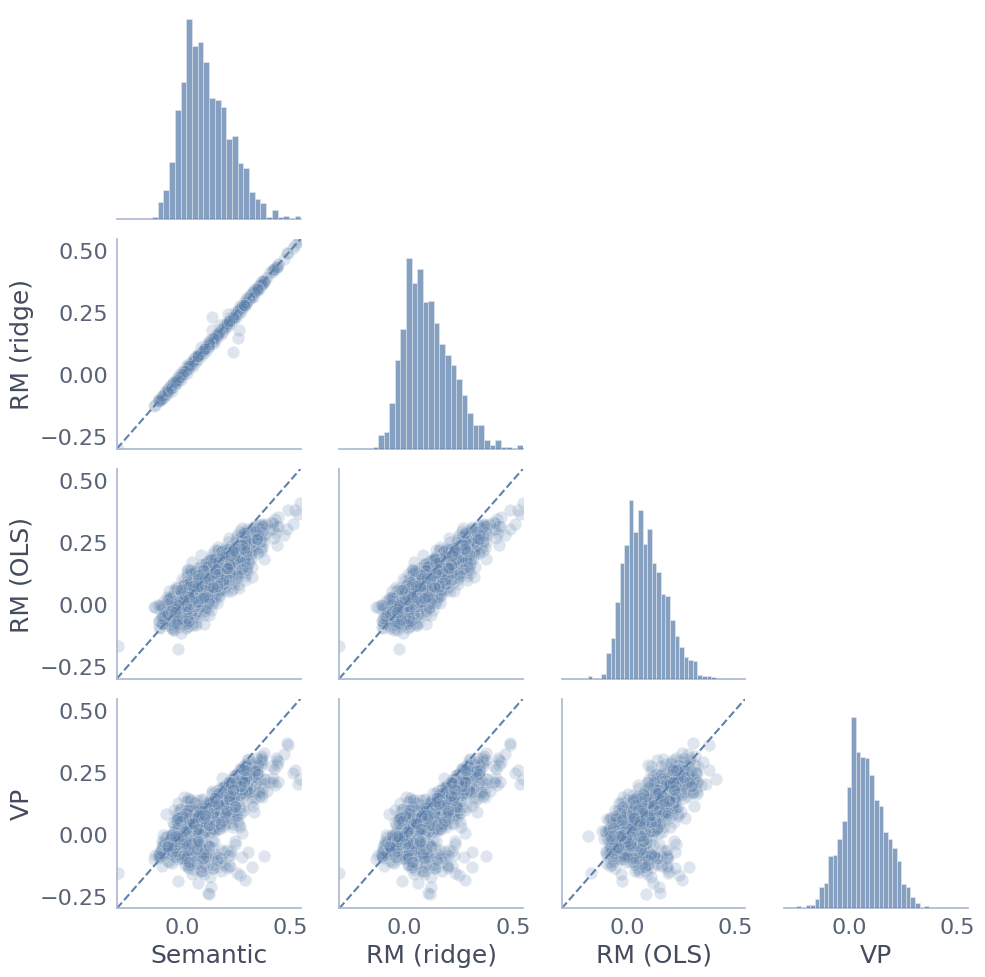

In [16]:
for data in datas:
    vmin = data.min().min()
    vmax = data.max().max()
    g = sns.pairplot(data, corner=True, plot_kws=dict(alpha=0.2))

    # Loop through the axes
    for i, row in enumerate(g.axes):
        for j, ax in enumerate(row):
            # Apply same x and y limits to all axes
            if ax is not None:
                ax.set_xlim(vmin, vmax)
                ax.set_ylim(vmin, vmax)

                if i != j:  # Only modify non-diagonal plots
                    sns.lineplot(
                        x=[vmin, vmax],
                        y=[vmin, vmax],
                        ax=ax,
                        # color="red",
                        linestyle="dashed"
                    )